In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score
from tqdm import tqdm
import xgboost as xgb
import cvxpy as cp

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
X, Y = data.load_german()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)
subgroup_train = X_train.Sex.values
subgroup_test = X_test.Sex.values

## Model without fairness

In [8]:
parameters = {
    "eta" : [0.1, 0.3, 0.5],
    "n_estimators" : [7, 9, 11],
    "colsample_bytree" : [0.25, 0.5, 0.75],
    "max_depth" : [4, 6, 8],
    "l2_weight" : [0.1, 1, 100],
}
cv = GridSearchCV(models.XGBoostWrapper(), parameters, 
    scoring = "roc_auc",
)
cv.fit(X_train, Y_train)
idx = np.argmax(cv.cv_results_["mean_test_score"])
best_score = cv.cv_results_["mean_test_score"][idx]
best_score_std = cv.cv_results_["mean_test_score"][idx]
cv.best_params_, f"{best_score:.3f} +/- {best_score_std:.3f}"

({'colsample_bytree': 0.75,
  'eta': 0.5,
  'l2_weight': 1,
  'max_depth': 4,
  'n_estimators': 11},
 '0.741 +/- 0.741')

In [14]:
utils.eval_model_train_test(
    cv,
    X_train, Y_train, subgroup_train,
    X_test, Y_test, subgroup_test,
)

,roc,tpr,fpr,threshold,recall,accuracy,precision,name
0,0.922734,0.893617,0.189873,0.657003,0.893617,0.870912,0.926471,train_g0
1,0.940260,0.867816,0.157895,0.657003,0.867816,0.858736,0.909639,train_g1
2,0.825359,0.763158,0.333333,0.657003,0.763158,0.733945,0.840580,test_g0
3,0.746032,0.703704,0.357143,0.657003,0.703704,0.682927,0.791667,test_g1


## Model with reinforcement for woman

In [18]:
def logloss_grad(predt, dtrain):
    '''Compute the gradient for log loss.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)
    return grad

def logloss_hessian(predt, dtrain):
    '''Compute the hessian for log loss.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))
    return hess

In [19]:
def logloss_grad_unpr(predt, dtrain, subgroup):
    '''Compute the gradient for log loss.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)
    grad[subgroup == 0] = 0
    return grad

def logloss_hessian_unpr(predt, dtrain, subgroup):
    '''Compute the hessian for log loss.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))
    hess[subgroup == 0] = 0
    return hess

In [27]:
def custom_obj(subgroup_idx, fair_weight):
    def custom_obj_(predt, dtrain):
        subgroup = (dtrain.get_data()[:, subgroup_idx]).toarray().reshape(-1)
        weight_1 = 1 / len(subgroup)
        weight_2 = fair_weight / subgroup.sum()
        grad = weight_1 * logloss_grad(predt, dtrain) + weight_2 * logloss_grad_unpr(predt, dtrain, subgroup)
        hess = weight_1 * logloss_hessian(predt, dtrain) + weight_2 * logloss_hessian_unpr(predt, dtrain, subgroup)
        return grad, hess
    return custom_obj_

In [72]:
parameters = {
    #"eta" : [0.1, 0.3, 0.5],
    "n_estimators" : [7, 9, 11],
    "colsample_bytree" : [0.25, 0.5, 0.75],
    "max_depth" : [4, 6, 8],
    "l2_weight" : [0.1, 1, 100],
    "min_child_weight" : [0, 0.01, 0.1],
}

In [73]:
lambda_values = np.append([0],np.logspace(-3, 3, num=20))
results = []
for lambda_value in tqdm(lambda_values):
    cv = GridSearchCV(models.XGBoostWrapper(objective = custom_obj(0, lambda_value)), parameters)
    cv.fit(X_train, Y_train)
    results_df = utils.eval_model_train_test(
        cv,
        X_train, Y_train, subgroup_train,
        X_test, Y_test, subgroup_test,
    )
    results_df["lambda"] = lambda_value
    results_df["best_params"] = str(cv.best_params_)
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [12:58<00:00, 37.05s/it]


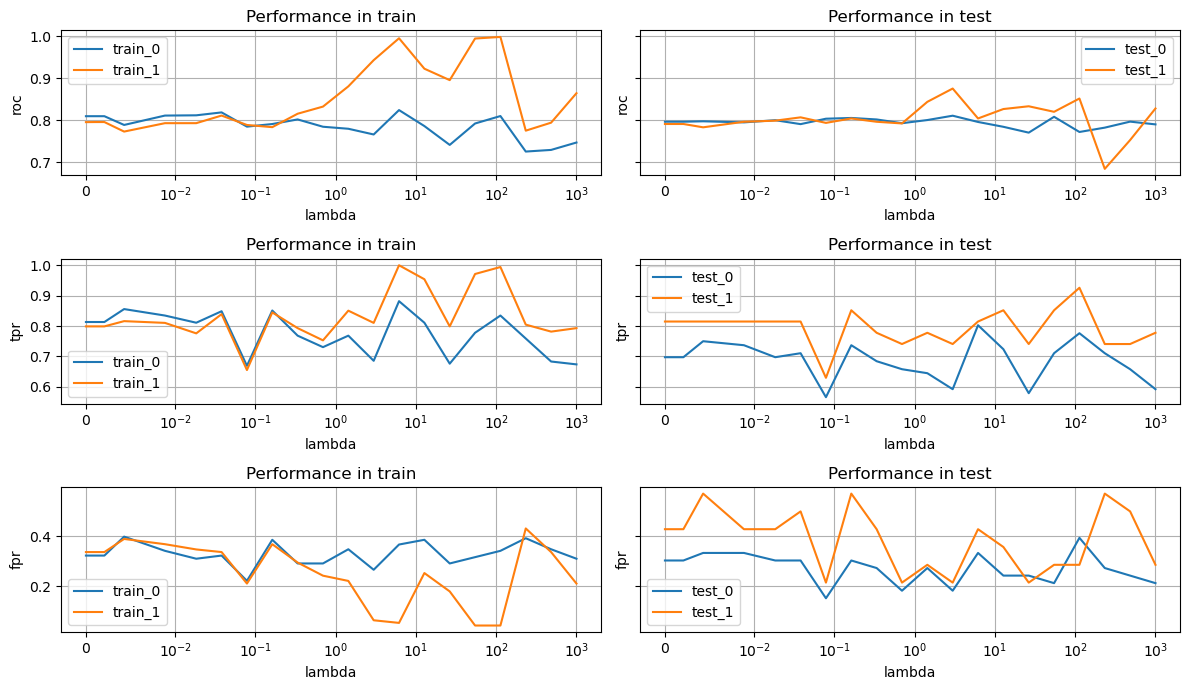

In [74]:
utils.comparison_subgrous_metrics_lambda(results)

## Model with dual step

In [75]:
def logloss_group(predt, dtrain, subgroup):
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    loss = - (y * np.log(predt) + (1 - y) * np.log(1 - predt))
    groups = np.unique(subgroup)
    loss_matrix = np.zeros((len(y), len(groups)))

    for i, group in enumerate(groups):
        loss_matrix[:, i] = loss # copy the column
        loss_matrix[subgroup!= group, i] = 0 # and set 0 for other groups

    loss_matrix = np.sum(loss_matrix, axis = 0)  / np.sum(loss_matrix != 0, axis = 0)
    return loss_matrix


def logloss_grad_group(predt, dtrain, subgroup):
    '''Compute the gradient for log loss for each group.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)

    groups = np.unique(subgroup)
    grad_matrix = np.zeros((len(y), len(groups)))

    for i, group in enumerate(groups):
        grad_matrix[:, i] = grad # copy the column
        grad_matrix[subgroup!= group, i] = 0 # and set 0 for other groups
    return grad_matrix


def logloss_hessian_group(predt, dtrain, subgroup):
    '''Compute the hessian for log loss for each group.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))

    groups = np.unique(subgroup)
    hess_matrix = np.zeros((len(hess), len(groups)))

    for i, group in enumerate(groups):
        hess_matrix[:, i] = hess # copy the column
        hess_matrix[subgroup!= group, i] = 0 # and set 0 for other groups
    return hess_matrix

In [76]:
def custom_obj(subgroup_idx, fair_weight):
    weight_1 = 1
    weight_2 = fair_weight
    
    def custom_obj_(predt, dtrain):

        subgroup = (dtrain.get_data()[:, subgroup_idx]).toarray().reshape(-1)
        
        # dual problem
        loss_group = logloss_group(predt, dtrain, subgroup)
        mu = cp.Variable(loss_group.shape[0]) # number of groups
        z = cp.Variable(1) # z is the min of mu * loss
        constraints = [cp.sum(mu) == fair_weight, mu >= 0] + [z <= mu[i] * loss_group[i] for i in range(loss_group.shape[0])]
        objective = cp.Maximize(z)
        problem = cp.Problem(objective, constraints)
        problem.solve()

        # primal problem
        mu_opt = mu.value
        grad_group = logloss_grad_group(predt, dtrain, subgroup)
        hess_group = logloss_hessian_group(predt, dtrain, subgroup)
        grad = logloss_grad(predt, dtrain) * weight_1 + np.sum(mu_opt * grad_group, axis=1) * weight_2
        hess = logloss_hessian(predt, dtrain) * weight_1 + np.sum(mu_opt * hess_group, axis=1) * weight_2
        return grad, hess
    return custom_obj_

In [79]:
lambda_values = np.append([0],np.logspace(-3, 3, num=20))
results = []
for lambda_value in tqdm(lambda_values):
    cv = GridSearchCV(models.XGBoostWrapper(objective = custom_obj(0, lambda_value)), parameters)
    cv.fit(X_train, Y_train)
    results_df = utils.eval_model_train_test(
        cv,
        X_train, Y_train, subgroup_train,
        X_test, Y_test, subgroup_test,
    )
    results_df["lambda"] = lambda_value
    results_df["best_params"] = str(cv.best_params_)
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
utils.comparison_subgrous_metrics_lambda(results)